In [1]:
from math import pi, erfc
import numpy as np
import scipy.signal
import scipy.interpolate
import matplotlib.pyplot as plt
import wavio

In [2]:
sr = 44100
wav = wavio.read("dirac16_44_stereo.wav")
channel_data = wav.data[:, 0] / 32767.0

In [3]:
# Tapped Delay Line

time = np.array([1, 307, 541, 955, 1055, 1511, 1523, 1531, 1699, 1867, 1987, 3055, 3321, ])
gain = np.array([-0.9, -0.02, -0.05, 0.75, 0.56, 0.4, -0.45, -0.52, -0.37, 0.3, 0.3, -0.13, 0.12])
sample = np.around(time).astype(int)

numerator = np.zeros(int(sample[-1])+1)
denominator = 1

for i in range(0, len(sample)):
    numerator[sample[i]] = gain[i]
    
channel_data = scipy.signal.lfilter(numerator, denominator, channel_data)

# Feedback Comb Filter

lbcf_delaylist = np.array([2200, 2926, 2956, 3744])
comb_size = len(lbcf_delaylist)
roomsize = np.array([0.45, 0.49, 0.52, 0.39])
damp = np.array([0.45, 0.42, 0.39, 0.36])

lbcf_output = []

for i in range(len(lbcf_delaylist)):
    delaysample = lbcf_delaylist[i]
    arraysize = delaysample + 1

    numerator = np.zeros(arraysize + 1)
    denominator = np.zeros(arraysize)

    numerator[arraysize-1] = 1
    numerator[arraysize] = -damp[i]

    denominator[0] = 1
    denominator[1] = -damp[i]
    denominator[arraysize-1] = -roomsize[i]*(1-damp[i])

    lbcf_output.append(scipy.signal.lfilter(numerator, denominator, channel_data))

channel_data = sum(lbcf_output)/comb_size

# All-Pass Filter

g = 0.7
apf_delaylist = np.array([1511])

for i in range(len(apf_delaylist)):
    delaysample = apf_delaylist[i]
    arraysize = delaysample+1

    numerator = np.zeros(arraysize)
    denominator = np.zeros(arraysize)
    
    numerator[0] = g
    numerator[delaysample] = 1

    denominator[0] = 1
    denominator[delaysample] = g
    
    channel_data = scipy.signal.lfilter(numerator, denominator, channel_data)
    
g = 0.7
apf_delaylist = np.array([1523])

for i in range(len(apf_delaylist)):
    delaysample = apf_delaylist[i]
    arraysize = delaysample+1

    numerator = np.zeros(arraysize)
    denominator = np.zeros(arraysize)
    
    numerator[0] = g
    numerator[delaysample] = 1

    denominator[0] = 1
    denominator[delaysample] = g
    
    channel_data = scipy.signal.lfilter(numerator, denominator, channel_data)
    
g = 0.7
apf_delaylist = np.array([1531])

for i in range(len(apf_delaylist)):
    delaysample = apf_delaylist[i]
    arraysize = delaysample+1

    numerator = np.zeros(arraysize)
    denominator = np.zeros(arraysize)
    
    numerator[0] = g
    numerator[delaysample] = 1

    denominator[0] = 1
    denominator[delaysample] = g
    
    channel_data = scipy.signal.lfilter(numerator, denominator, channel_data) 

# channel_data = channel_data / max(channel_data)

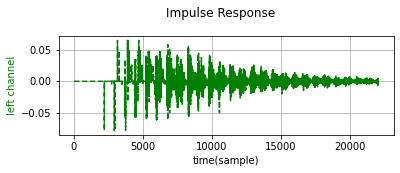

In [4]:
x_axis = np.arange(len(channel_data))

plt.figure(1)
plt.suptitle('Impulse Response')

plt.subplot(211)
plt.plot(x_axis, channel_data, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

In [5]:
def echoDensity(IR, N, fs, preDelay):
    mixingThresh = 1.0
    s = np.zeros(len(IR))
    echo_dens = np.zeros(len(IR))

    wTau = scipy.signal.hann(N).T
    wTau = wTau / sum(wTau)
    halfWin = round(N / 2)

    sparseInd = np.arange(0, len(IR), 500)

    for n in sparseInd:
        if n <= halfWin + 1:
            hTau = IR[0:n + halfWin].T
            # end = int(wTau[-1])
            wT = wTau[(-1 - halfWin - n + 1):]

        elif (n > halfWin+1) and (n <= len(IR)-halfWin+1):
            hTau = IR[(n - halfWin):(n + halfWin)].T
            wT = wTau

        elif n > len(IR)-halfWin+1:
            hTau = IR[n - halfWin:].T
            wT = wTau[0:len(hTau)]

        s[n] = np.sqrt(np.dot(wT, (hTau * hTau)))

        tipCt = np.zeros(len(hTau))
        for i in range(len(hTau)):
            if abs(hTau[i]) > s[n]:
                tipCt[i] = 1
            else:
                tipCt[i] = 0

        echo_dens[n] = np.dot(wT, tipCt.T)

    echo_dens = echo_dens / erfc(1 / np.sqrt(2))
    fill = np.arange(0, len(IR))
    echo_dens_new = scipy.interpolate.interp1d(sparseInd, echo_dens[sparseInd],axis=0, fill_value="extrapolate")
        # a = (echo_dens[sparseInd])
        # d = np.argwhere(echo_dens > mixingThresh)[0]
        # t_abel = (d -preDelay)/fs * 1000
    return echo_dens_new(fill)

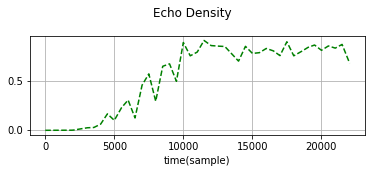

In [6]:
mean = sum(channel_data)/len(channel_data)
result = echoDensity(channel_data, 512, sr, 0)
plt.figure(1)
plt.suptitle('Echo Density')

plt.subplot(211)
plt.plot(result, 'g--')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

In [7]:
def Echo_Density_Measure(raw_input_data, beta):
    
    # to make data to be zero mean
    mean = np.full((len(raw_input_data)), sum(raw_input_data) / len(raw_input_data))
    temp = raw_input_data - mean
    # add zeros both in the head and tail
    input_data = np.insert(np.zeros(beta*2), beta, temp)
    
    # total size of rendered impulse response
    size = len(input_data)
    
    # to make a full window from beta(half window size)
    window_size = 2 * beta + 1
    
    # to storage frame 
    buffer = np.zeros(window_size)
    
    # to storage indicator function result
    indicatorBuffer = np.zeros(window_size)
    
    # iteration of sliding index 
    slidingFrame = size - window_size + 1
    outputBuffer = np.zeros(slidingFrame)
    
    for tau in range(slidingFrame):
        start = tau
        end = tau + window_size
        buffer = input_data[start:end]
        sd = np.sqrt(np.dot(buffer, buffer) / window_size)
        
        for index, element in enumerate(buffer): 
            indicatorBuffer[index] = Indicator_Function(element, sd)
        outputBuffer[tau] = sum(indicatorBuffer) / window_size / erfc(1 / np.sqrt(2))
    
    return input_data, outputBuffer

def Weighted_Echo_Density_Measure(raw_input_data, beta):
    
    # to make data to be zero mean
    mean = np.full((len(raw_input_data)), sum(raw_input_data) / len(raw_input_data))
    temp = raw_input_data - mean
    # add zeros both in the head and tail
    input_data = np.insert(np.zeros(beta*2), beta, temp)    
    
    # total size of rendered impulse response
    size = len(input_data)
    
    # to make a full window from beta(half window size)
    window_size = 2 * beta + 1
    
    # normalized to have unit sum, 1
    raw_window = scipy.signal.hann(window_size)
    window = raw_window/sum(raw_window)
    
    # to storage frame 
    buffer = np.zeros(window_size)
    
    # to storage indicator function result
    indicatorBuffer = np.zeros(window_size)
    
    # iteration of sliding index 
    slidingFrame = size - window_size + 1
    outputBuffer = np.zeros(slidingFrame)
    
    for tau in range(slidingFrame):
        start = tau
        end = tau + window_size
        buffer = input_data[start:end]
        sd = np.sqrt(np.dot(window.T, np.multiply(buffer, buffer)))
        
        
        for index, element in enumerate(buffer): 
            indicatorBuffer[index] = Indicator_Function(element, sd)
        outputBuffer[tau] = np.dot(window.T, indicatorBuffer) / erfc(1 / np.sqrt(2))
    
    return input_data, outputBuffer

def Indicator_Function(input_data, standard_deviation):
    if(input_data > standard_deviation): 
        return 1
    else:
        return 0

In [8]:
beta = 128
preProcessing1, res1 = Echo_Density_Measure(channel_data, beta)
preProcessing2, res2 = Weighted_Echo_Density_Measure(channel_data, beta)

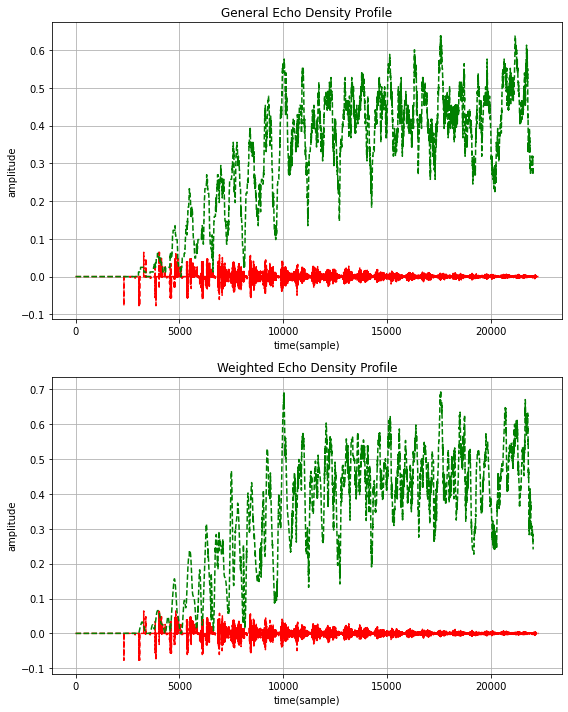

In [13]:
plt.figure(figsize=(8,10))
plt.figure(1)

plt.subplot(211)
plt.title("General Echo Density Profile")
plt.plot(preProcessing1, 'r--')
plt.plot(res1, 'g--')
# plt.xscale("log")
# plt.xlim(2000, 22050)
plt.grid()
plt.xlabel(r'time(sample)')
plt.ylabel(r'amplitude')

plt.subplot(212)
plt.title("Weighted Echo Density Profile")
plt.plot(preProcessing2, 'r--')
plt.plot(res2, 'g--')
# plt.xscale("log")
# plt.xlim(2000, 22050)
plt.grid()
plt.xlabel(r'time(sample)')
plt.ylabel(r'amplitude')

plt.tight_layout()
plt.show()